# Seldon Deployment Pipeline For CIFAR10 Image Recognition

In this example (and Kale Kubeflow pipeline) we create a deployment pipeline for a pretrained CIFAR10 image model. 
The following steps will be run:

 * Setup Minio client
 * Download and test CIFAR10 model and train an Anchors Images explainer on it. Save both model and explainer to Minio.
 * Deploy model and explainer using Seldon and test
 * Train outlier detector
 * Train drift detector
 * Deploy knative eventing display to show asynchronous results from outlier and drift detectors. 
 * Deploy outlier detector and test
 * deploy drift detector and test
 
 ### Setup
 
 You will need a kubeflow cluster >= 1.0 with 
   
  * Knative eventing 
  * Seldon >= 1.2.1
 
 ### Kubeflow Jupyter Notebook Server
 
 To run this notebook inside kubeflow. Create a Jupyter notebook server using the image `seldonio/jupyter-lab-alibi-kale:0.11`
 
 ### GCP Setup
 
 On GCP If you use Kale to save this notebook as a pipeline you will need to add the storage_class of the `VolumeOp` to `nfs-client` if you have followed the steps to create a NFS RWX PV on GCP. e.g.:
 
 ```
    marshal_vop = dsl.VolumeOp(
        name="kale-marshal-volume",
        resource_name="kale-marshal-pvc",
        storage_class="nfs-client",
        modes=dsl.VOLUME_MODE_RWM,
        size="1Gi"
    )
 ```
 

 

In [205]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from alibi.explainers import AnchorImage
from alibi.datasets import fetch_adult
from minio import Minio
from minio.error import ResponseError
from joblib import dump, load
import dill
from subprocess import run, Popen, PIPE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_tf_model
import json
import logging
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import time

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Setup Pipeline Paramers

The following global variables can be set. These will be used as Pipeline parameters.

In [2]:
MINIO_HOST="minio-service.kubeflow:9000"
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="minio123"
MINIO_MODEL_BUCKET="seldon"
CIFAR10_MODEL_PATH="tfserving/cifar10/model"
EXPLAINER_MODEL_PATH="tfserving/cifar10/explainer"
OUTLIER_MODEL_PATH="tfserving/cifar10/outlier"
DRIFT_MODEL_PATH="tfserving/cifar10/drift"
DEPLOY_NAMESPACE="admin"
TRAIN_OUTLIER_DETECTOR=False
TRAIN_DRIFT_DETECTOR=False

In [3]:
def get_minio():
    return Minio(MINIO_HOST,
                    access_key=MINIO_ACCESS_KEY,
                    secret_key=MINIO_SECRET_KEY,
                    secure=False)

In [4]:
minioClient = get_minio()
buckets = minioClient.list_buckets()
for bucket in buckets:
    print(bucket.name, bucket.creation_date)

mlpipeline 2020-07-04 08:55:55.417000+00:00
mybucket 2020-07-17 09:54:33.136000+00:00
seldon 2020-07-24 19:24:13.525000+00:00


In [5]:
if not minioClient.bucket_exists(MINIO_MODEL_BUCKET):
    minioClient.make_bucket(MINIO_MODEL_BUCKET)

## Test and save Model

For simplicity we will use a pretrained Resnet32 CIFAR10 tensorflow model

In [6]:
model = fetch_tf_model('cifar10', 'resnet32')

In [129]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [130]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Test model locally.

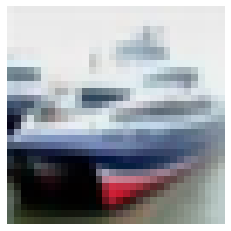

class: ship
prediction: ship


In [131]:
idx = 1
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[model.predict(X_test[idx:idx+1])[0].argmax()])

In [11]:
modelfilepath="resnet"
tf.saved_model.save(model, modelfilepath)

In [38]:
from os import listdir
from os.path import isfile, join

model_filepath="resnet"
print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{CIFAR10_MODEL_PATH}/1/saved_model.pb", modelfilepath+"/saved_model.pb"))
variable_filepath = modelfilepath+"/variables"
onlyfiles = [f for f in listdir(variable_filepath) if isfile(join(variable_filepath, f))]
for filename in onlyfiles:
    print(filename)
    print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{CIFAR10_MODEL_PATH}/1/variables/{filename}", join(variable_filepath, filename)))

5802f0744ecd95980ae71e2d8406dff9
variables.index
9d763b73c8e4346c49fd793c5fface02
variables.data-00000-of-00001
c04c836b36bbdf8eca2ff822a7528cfa


## Train Explainer

In [10]:
def predict_fn(x):
    return model.predict(x)

In [39]:

image_shape = (32, 32, 3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 5, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

In [40]:
idx=0
image = X_test[0]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)

/usr/local/lib/python3.6/dist-packages/alibi/explainers/anchor_image.py:58: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  self.segmentation_fn = lambda x: fn_options[segmentation_fn](x, **segmentation_kwargs)


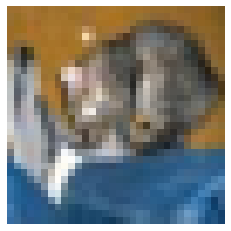

class: cat
prediction: cat


In [41]:
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[model.predict(X_test[idx:idx+1])[0].argmax()])

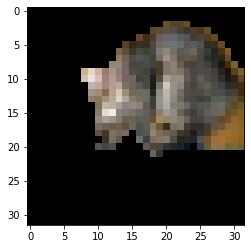

In [42]:
plt.imshow(explanation["anchor"])

In [43]:
with open("explainer.dill", "wb") as dill_file:
    dill.dump(explainer, dill_file)    
    dill_file.close()
print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{EXPLAINER_MODEL_PATH}/explainer.dill", 'explainer.dill'))

6a34585d6aa8632af62b7e0272a9b5a6


## Train Outlier Detector

For further details and extended notebook see [Alibi-Detect Documentation](https://docs.seldon.io/projects/alibi-detect/en/stable/). These steps were derived from [Alibi-Detect CIFAR10 Example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html)

In [11]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [12]:
if TRAIN_OUTLIER_DETECTOR:
    latent_dim = 1024
    
    encoder_net = tf.keras.Sequential(
        [
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
            Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
            Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
        ])

    decoder_net = tf.keras.Sequential(
        [
            InputLayer(input_shape=(latent_dim,)),
            Dense(4*4*128),
            Reshape(target_shape=(4, 4, 128)),
            Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
            Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
            Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
        ])
    
     # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=2)
    # train
    od.fit(X_train, 
            loss_fn=elbo,
            cov_elbo=dict(sim=.05),
            epochs=50,
            verbose=True)
else:
    od = load_detector("/home/models/samples/od/cifar10")

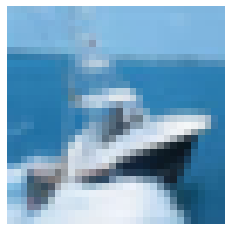

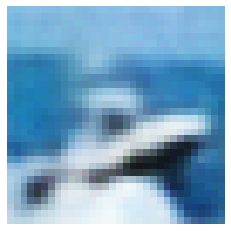

In [13]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

(500, 32, 32, 3)
['instance_score', 'feature_score', 'is_outlier']


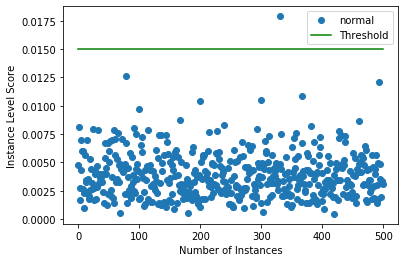

In [47]:
X = X_train[:500]
print(X.shape)
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

In [76]:
from alibi_detect.utils.saving import save_detector, load_detector
from os import listdir
from os.path import isfile, join

filepath="cifar10outlier"
save_detector(od, filepath) 
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
for filename in onlyfiles:
    print(filename)
    print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{OUTLIER_MODEL_PATH}/{filename}", join(filepath, filename)))
filepath="cifar10outlier/model"
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
for filename in onlyfiles:
    print(filename)
    print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{OUTLIER_MODEL_PATH}/model/{filename}", join(filepath, filename)))

meta.pickle
d344a072b9815ecd0a83d6568e71d0f6
OutlierVAE.pickle
73a38ab3f74a4f79450a57f0c2febc7c
checkpoint
015e9f3bd7a74329e08145d3f7050793
vae.ckpt.data-00000-of-00001
8da126448dd9422f2de675d6e2a69db0-16
decoder_net.h5
9cda33223505719264befd67f28fcdc0-3
encoder_net.h5
f0fdd814527bcaca2a326614c304d98f
vae.ckpt.index
2c6f4622d4f66eae7b516426b01d380a


## Train a Drift Detector

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import uae, hidden_output
from alibi_detect.models.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

In [135]:
tf.random.set_seed(0)

if True:
    np.random.seed(0)
    n_test = X_test.shape[0]
    idx = np.random.choice(n_test, size=n_test // 2, replace=False)
    idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
    X_ref,y_ref = X_test[idx], y_test[idx]
    X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
    print(X_ref.shape, X_h0.shape)
    # define encoder
    encoding_dim = 32
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
          Flatten(),
          Dense(encoding_dim,)
      ]
    )

    # initialise drift detector
    p_val = .05
    cd = KSDrift(
        p_val=p_val,        # p-value for K-S test
        X_ref=X_ref,       # test against original test set
        preprocess_fn=uae,  # UAE for dimensionality reduction
        preprocess_kwargs={'encoder_net': encoder_net, 'batch_size': 128},
        alternative='two-sided'  # other options: 'less', 'greater'
    )
else:
    cd = load_detector("/home/models/samples/cd/cifar10")

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [136]:
from alibi_detect.utils.saving import save_detector, load_detector
from os import listdir
from os.path import isfile, join

filepath="cifar10Drift"
save_detector(cd, filepath) 
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
for filename in onlyfiles:
    print(filename)
    print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{DRIFT_MODEL_PATH}/{filename}", join(filepath, filename)))
filepath="cifar10Drift/model"
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
for filename in onlyfiles:
    print(filename)
    print(get_minio().fput_object(MINIO_MODEL_BUCKET, f"{DRIFT_MODEL_PATH}/model/{filename}", join(filepath, filename)))

meta.pickle
7696b4091e11e818315549d461734ef3
KSDrift.pickle
671ace6c985686e0e891d36cc9e7ce90-12
encoder_net.h5
577fd070aa0a14ce09d1813e4106ed0e-2


## Deploy Seldon Core Model

In [84]:
secret = f"""apiVersion: v1
kind: Secret
metadata:
  name: seldon-init-container-secret
  namespace: {DEPLOY_NAMESPACE}
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: {MINIO_ACCESS_KEY}
  AWS_SECRET_ACCESS_KEY: {MINIO_SECRET_KEY}
  AWS_ENDPOINT_URL: http://{MINIO_HOST}
  USE_SSL: "false"
"""
with open("secret.yaml","w") as f:
    f.write(secret)
run("cat secret.yaml | kubectl apply -f -", shell=True)

CompletedProcess(args='cat secret.yaml | kubectl apply -f -', returncode=0)

In [85]:
sa = f"""apiVersion: v1
kind: ServiceAccount
metadata:
  name: minio-sa
  namespace: {DEPLOY_NAMESPACE}
secrets:
  - name: seldon-init-container-secret
"""
with open("sa.yaml","w") as f:
    f.write(sa)
run("kubectl apply -f sa.yaml", shell=True)

CompletedProcess(args='kubectl apply -f sa.yaml', returncode=0)

In [91]:
model_yaml=f"""apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10-classifier
  namespace: {DEPLOY_NAMESPACE}
spec:
  protocol: tensorflow
  predictors:
  - componentSpecs:
    graph:
      implementation: TENSORFLOW_SERVER
      modelUri: s3://{MINIO_MODEL_BUCKET}/{CIFAR10_MODEL_PATH}
      envSecretRefName: seldon-init-container-secret
      name: classifier
      logger:
         mode: all
    explainer:
      type: AnchorImages
    name: default
    replicas: 1
"""
with open("model.yaml","w") as f:
    f.write(model_yaml)
run("kubectl apply -f model.yaml", shell=True)

CompletedProcess(args='kubectl apply -f model.yaml', returncode=0)

In [76]:
run(f"kubectl rollout status -n {DEPLOY_NAMESPACE} deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{{.items[0].metadata.name}}' -n {DEPLOY_NAMESPACE})", shell=True)

CompletedProcess(args="kubectl rollout status -n admin deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{.items[0].metadata.name}' -n admin)", returncode=0)

In [77]:
run(f"kubectl rollout status -n {DEPLOY_NAMESPACE} deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{{.items[1].metadata.name}}' -n {DEPLOY_NAMESPACE})", shell=True)

CompletedProcess(args="kubectl rollout status -n admin deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{.items[1].metadata.name}' -n admin)", returncode=0)

Make a prediction request

{
    "predictions": [[0.863314629, 5.19057312e-06, 0.00059614022, 0.0777486488, 0.000802330906, 0.0537538, 0.003750148, 1.13876849e-05, 1.45650574e-05, 3.15050033e-06]
    ]
}


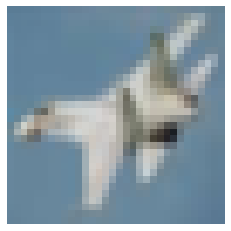

class: airplane
prediction: airplane


In [216]:
def test_model():
 idx=10
 test_example=X_test[idx:idx+1].tolist()
 payload='{"instances":'+f"{test_example}"+' }'
 cmd=f"""curl -d '{payload}' \
   http://cifar10-classifier-default.{DEPLOY_NAMESPACE}:8000/v1/models/classifier/:predict \
   -H "Content-Type: application/json"
 """
 ret = Popen(cmd, shell=True,stdout=PIPE)
 raw = ret.stdout.read().decode("utf-8")
 print(raw)
 res=json.loads(raw)
 arr=np.array(res["predictions"])
 X = X_test[idx].reshape(1, 32, 32, 3)
 plt.imshow(X.reshape(32, 32, 3))
 plt.axis('off')
 plt.show()
 print("class:",class_names[y_test[idx][0]])
 print("prediction:",class_names[arr[0].argmax()])

ok = False
while not ok:
    try:
        test_model()
        ok = True
    except:
        print("Failed calling model, sleeping")
        time.sleep(2)

Make an explanation request

In [104]:
idx=10
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://cifar10-classifier-default-explainer.{DEPLOY_NAMESPACE}:9000/v1/models/cifar10-classifier/:explain \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
print(raw)

<html><title>404: Not Found</title><body>404: Not Found</body></html>


## Deploy KNative Eventing Event Display

In [186]:
event_display=f"""apiVersion: apps/v1
kind: Deployment
metadata:
  name: event-display
  namespace: {DEPLOY_NAMESPACE}          
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: event-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: helloworld-go
          # Source code: https://github.com/knative/eventing-contrib/tree/master/cmd/event_display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display@sha256:f4628e97a836c77ed38bd3b6fd3d0b06de4d5e7db6704772fe674d48b20bd477
---
kind: Service
apiVersion: v1
metadata:
  name: event-display
  namespace: {DEPLOY_NAMESPACE}
spec:
  selector:
    app: event-display
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8080
---
apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: cifar10-outlier-display
  namespace: {DEPLOY_NAMESPACE}
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.outlier
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: event-display
---
apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: cifar10-drift-display
  namespace: {DEPLOY_NAMESPACE}
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.drift
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: event-display
"""
with open("event_display.yaml","w") as f:
    f.write(event_display)
run("kubectl apply -f event_display.yaml", shell=True)

CompletedProcess(args='kubectl apply -f event_display.yaml', returncode=0)

In [30]:
run(f"kubectl rollout status -n {DEPLOY_NAMESPACE} deploy/event-display -n {DEPLOY_NAMESPACE}", shell=True)

CompletedProcess(args='kubectl rollout status -n admin deploy/event-display -n admin', returncode=0)

## Deploy Seldon Outlier Detector

In [187]:
outlier_yaml=f"""apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: cifar10-outlier
  namespace: {DEPLOY_NAMESPACE}
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.2.1
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --protocol
        - tensorflow.http
        - --storage_uri
        - s3://{MINIO_MODEL_BUCKET}/{OUTLIER_MODEL_PATH}
        - --reply_url
        - http://default-broker       
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        envFrom:
        - secretRef:
            name: seldon-init-container-secret
"""
with open("outlier.yaml","w") as f:
    f.write(outlier_yaml)
run("kubectl apply -f outlier.yaml", shell=True)

CompletedProcess(args='kubectl apply -f outlier.yaml', returncode=0)

In [188]:
trigger_outlier_yaml=f"""apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: cifar10-outlier-trigger
  namespace: {DEPLOY_NAMESPACE}
spec:
  filter:
    sourceAndType:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: cifar10-outlier
"""
with open("outlier_trigger.yaml","w") as f:
    f.write(trigger_outlier_yaml)
run("kubectl apply -f outlier_trigger.yaml", shell=True)

CompletedProcess(args='kubectl apply -f outlier_trigger.yaml', returncode=0)

In [189]:
run(f"kubectl rollout status -n {DEPLOY_NAMESPACE} deploy/$(kubectl get deploy -l serving.knative.dev/service=cifar10-outlier -o jsonpath='{{.items[0].metadata.name}}' -n {DEPLOY_NAMESPACE})", shell=True)

CompletedProcess(args="kubectl rollout status -n admin deploy/$(kubectl get deploy -l serving.knative.dev/service=cifar10-outlier -o jsonpath='{.items[0].metadata.name}' -n admin)", returncode=0)

## Test Seldon Outlier Detection

In [190]:
idx = 1
X = X_train[idx:idx+1]

In [191]:
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))


{
    "predictions": [[0.00352378725, 0.000146826991, 2.74114227e-05, 0.0080165891, 2.3886334e-05, 5.01702834e-06, 1.66823793e-05, 5.46571482e-06, 0.931635201, 0.0565991588]
    ]
}


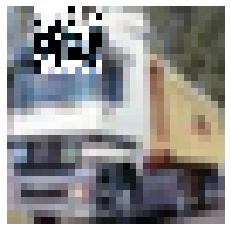

class: truck
prediction: ship


In [192]:
test_example=X_mask.tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://cifar10-classifier-default.{DEPLOY_NAMESPACE}:8000/v1/models/classifier/:predict \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
print(raw)
res=json.loads(raw)
arr=np.array(res["predictions"])
plt.imshow(X_mask.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_train[idx][0]])
print("prediction:",class_names[arr[0].argmax()])

In [210]:
def get_outlier_event_display_logs():
    cmd=f"kubectl logs $(kubectl get pod -l app=event-display -o jsonpath='{{.items[0].metadata.name}}' -n {DEPLOY_NAMESPACE}) -n {DEPLOY_NAMESPACE}"
    ret = Popen(cmd, shell=True,stdout=PIPE)
    res = ret.stdout.read().decode("utf-8").split("\n")
    data= []
    for i in range(0,len(res)):
        if res[i] == 'Data,':
            j = json.loads(json.loads(res[i+1]))
            if "is_outlier"in j["data"].keys():
                data.append(j)
    if len(data) > 0:
        return data[-1]
    else:
        return None
j = None
while j is None:
    print("Waiting for outlier logs, sleeping")
    time.sleep(2)
    j = get_outlier_event_display_logs()
    
print(j)
print("Outlier",j["data"]["is_outlier"]==[1])

Waiting for outlier logs, sleeping
{'data': {'instance_score': None, 'feature_score': None, 'is_outlier': [1]}, 'meta': {'name': 'OutlierVAE', 'detector_type': 'offline', 'data_type': 'image'}}
Outlier True


## Deploy Seldon Drift Detector

In [220]:
drift_yaml=f"""apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: cifar10-drift
  namespace: {DEPLOY_NAMESPACE}
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.2.2-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10cd
        - --protocol
        - tensorflow.http
        - --storage_uri
        - s3://{MINIO_MODEL_BUCKET}/{DRIFT_MODEL_PATH}
        - --reply_url
        - http://default-broker
        - --event_type
        - io.seldon.serving.inference.drift
        - --event_source
        - io.seldon.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '500'
        envFrom:
        - secretRef:
            name: seldon-init-container-secret
"""
with open("drift.yaml","w") as f:
    f.write(drift_yaml)
run("kubectl apply -f drift.yaml", shell=True)

CompletedProcess(args='kubectl apply -f drift.yaml', returncode=0)

In [195]:
trigger_outlier_yaml=f"""apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: cifar10-drift-trigger
  namespace: {DEPLOY_NAMESPACE}
spec:
  filter:
    sourceAndType:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: cifar10-drift
"""
with open("outlier_trigger.yaml","w") as f:
    f.write(trigger_outlier_yaml)
run("kubectl apply -f outlier_trigger.yaml", shell=True)

CompletedProcess(args='kubectl apply -f outlier_trigger.yaml', returncode=0)

In [200]:
run(f"kubectl rollout status -n {DEPLOY_NAMESPACE} deploy/$(kubectl get deploy -l serving.knative.dev/service=cifar10-drift -o jsonpath='{{.items[0].metadata.name}}' -n {DEPLOY_NAMESPACE})", shell=True)

CompletedProcess(args="kubectl rollout status -n admin deploy/$(kubectl get deploy -l serving.knative.dev/service=cifar10-drift -o jsonpath='{.items[0].metadata.name}' -n admin)", returncode=0)

## Test Seldon Drift Detector

In [221]:
def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

In [222]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

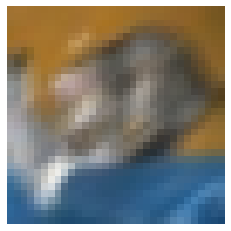

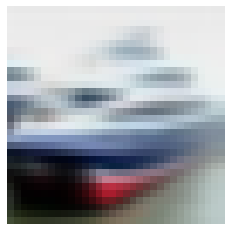

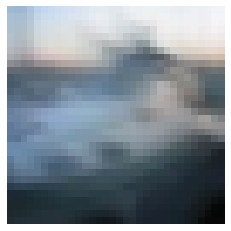

In [223]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])


In [151]:
def predict(X):
    test_example=X.tolist()
    payload='{"instances":'+f"{test_example}"+' }'
    with open("payload.json","w") as f:
        f.write(payload)
    cmd=f"""curl -d @./payload.json \
   http://cifar10-classifier-default.{DEPLOY_NAMESPACE}:8000/v1/models/classifier/:predict \
   -H "Content-Type: application/json"
    """
    run(cmd, shell=True)

In [228]:
for i in tqdm(range(0,1000,50)):
    X = X_corr[i:i+50]
    predict(X)

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


In [227]:
def get_drift_event_display_logs():
    cmd=f"kubectl logs $(kubectl get pod -l app=event-display -o jsonpath='{{.items[0].metadata.name}}' -n {DEPLOY_NAMESPACE}) -n {DEPLOY_NAMESPACE}"
    ret = Popen(cmd, shell=True,stdout=PIPE)
    res = ret.stdout.read().decode("utf-8").split("\n")
    data= []
    for i in range(0,len(res)):
        if res[i] == 'Data,':
            j = json.loads(json.loads(res[i+1]))
            if "is_drift"in j["data"].keys():
                data.append(j)
    if len(data) > 0:
        return data[-1]
    else:
        return None
j = None
while j is None:
    print("Waiting for drift logs, sleeping")
    time.sleep(2)
    j = get_drift_event_display_logs()
    
print(j)
print("Drift",j["data"]["is_drift"]==1)

Waiting for drift logs, sleeping
{'data': {'batch_score': None, 'feature_score': None, 'is_drift': 1, 'p_val': [0.004018960986286402, 0.45524972677230835, 0.2174428254365921, 0.06346634030342102, 0.5843484997749329, 0.002100310055539012, 0.1064653992652893, 0.4945363998413086, 0.027672482654452324, 0.6632086634635925, 0.05798501893877983, 0.04188045859336853, 0.762234091758728, 0.008826815523207188, 0.09795800596475601, 0.013353543356060982, 0.7204069495201111, 0.09195560961961746, 0.023188555613160133, 0.20599666237831116, 0.0031507129315286875, 0.011977119371294975, 0.2590944766998291, 0.6919310092926025, 0.22936709225177765, 0.000520448200404644, 0.1132398322224617, 0.0008694478310644627, 0.620048463344574, 0.008581497706472874, 0.03056463971734047, 0.03056463971734047]}, 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}
Drift True


## Clean up

In [229]:
run(f"kubectl delete sdep cifar10-classifier -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete ksvc cifar10-outlier -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete ksvc cifar10-drift -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete trigger --all -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete sa  minio-sa -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete secret seldon-init-container-secret -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete deployment event-display -n {DEPLOY_NAMESPACE}", shell=True)
run(f"kubectl delete svc event-display -n {DEPLOY_NAMESPACE}", shell=True)

CompletedProcess(args='kubectl delete svc event-display -n admin', returncode=0)